In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='sans-serif')

from tqdm import tqdm

import torch
import torch.distributions as dist
import h5py

from geobed import BED_discrete
import geobed.fwd_collection.raytracer as raytracer

In [3]:
filename_core = 'marmousi_vp_centersection'
filename = f"data/{filename_core}.npz"

with np.load(filename, allow_pickle=True) as marmousi_centersection:    
    x = marmousi_centersection['x']
    z = marmousi_centersection['z']
    marmousi_vp = marmousi_centersection['data']
    
# area of interest
e_x_min, e_x_max = min(x), max(x)
e_z_min, e_z_max = min(z), max(z)

dx, dz = x[1] - x[0], z[1] - z[0]

print(e_x_min, e_x_max)

3000.3185954411765 16500.503183088236


In [4]:
def construct_covmat(theta, ratio, scaling): 
    theta = -np.radians(theta)
    ratio = ratio
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    S = scaling * np.diag([ratio, 1])
    L = S**2
    return torch.tensor(R@L@R.T, dtype=dtype)

n_prior = int(2e7)
n_prior_plot = int(1e4)

# using float 32 for eveything to keep storage and loading times down
dtype, bytes = torch.float32, 4

mu1=torch.tensor([9.37, 1.91])*1e3
mu2=torch.tensor([10.1, 2.0])*1e3
mu3=torch.tensor([10.85, 2.01])*1e3
mu_list = [mu1, mu2, mu3]

cov1 = construct_covmat(10,  4, 0.12*1e3)
cov2 = construct_covmat(15,  6, 0.1*1e3)
cov3 = construct_covmat(5, 10, 0.08*1e3)
cov_list = [cov1, cov2, cov3]

mix = dist.Categorical(torch.tensor([0.3, 0.3, 0.3]))
comp = dist.MultivariateNormal(torch.stack(mu_list,axis=0),
                               covariance_matrix=torch.stack(cov_list, axis=0))

prior_dist = dist.MixtureSameFamily(mix, comp)

fig = plt.figure(figsize=(
                    (e_x_max-e_x_min)*1*0.8*1e-3,
                    (e_z_max-e_z_min)*1.5*0.8*1e-3), dpi=120)
ax_dict = fig.subplot_mosaic(
    '''aa
       aa''',
       gridspec_kw={'height_ratios': [1, 3], 'hspace': 0.05, 'width_ratios': [0.915, 0.085], 'wspace': 0.0},
       empty_sentinel='x', sharex=True)

receivers = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) *1e3

print(x.shape, z.shape, marmousi_vp.shape, np.vstack( [receivers, 0.5*1e3*np.ones((len(receivers)))] ).T.shape)

tt_H = raytracer.TTHelper()
tt_H.set_model( x= x,  y= np.array([0]),  z=z,
               dx=dx, dy=           1.0, dz=dz,
               velocity_model=marmousi_vp)

X, Z = np.meshgrid(x[::10], z[::10])
X, Z = X.flatten(), Z.flatten() 
XZ = np.column_stack([X, Z])

test = tt_H.calculate_tt_diff(np.array((mu2[0], mu2[1])), np.vstack([receivers, 0.5*1e3*np.ones((len(receivers)))] ).T)

print(test)
ax = tt_H.plot_model(
    vmin=800, vmax=5500,
    # prior_realisations=prior_dist.sample([n_prior_plot]).numpy(),
    pdf_dict={'x': x[::10], 'z': z[::10], 'pdf': torch.exp(prior_dist.log_prob(torch.tensor(XZ)).reshape(len(z[::10]), len(x[::10]))).numpy(),
              'cmap':'Blues'},
    colorbar=True,
    wells=mu_list,
    plot_rays=(mu2[0], mu2[1]),
    receivers=np.vstack( [receivers, 0.5*1e3*np.ones((len(receivers)))] ).T,
    receiver_alpha=0.0,
    im_cmap='Greys',
    ax=ax_dict['a'],)

ax.plot([], [], 'ob', label='prior pdf', alpha=0.5, markeredgecolor='none', markersize=10)
ax.plot([mu2[0]/1e3,], [mu2[1]/1e3,], '*r', label='example event', markersize=10, zorder=10)

ax_dict['a'].legend(loc='lower right')

fig.savefig(f'figures/setup_gmm.pdf', bbox_inches='tight', dpi=120)
fig.savefig(f'figures/setup_gmm.png', bbox_inches='tight', dpi=120)

plt.show()

(10809,) (1682,) (10809, 1682) (12, 2)


In [ ]:
prior_samples = prior_dist.sample( (n_prior,) )

print('dimensions: (n_prior, model_dim) n_prior is more or less the batchsize')
print(prior_samples.shape, '\n')

n_designs = int(200)

print(e_x_min, e_x_max )
print(e_z_min, e_z_max )

designs = torch.ones((n_designs, 2))
designs[: ,0] = torch.linspace(3.1, 16.4, n_designs)*1e3
designs[: ,1] = 0.51 * torch.ones_like(designs[: ,0])*1e3

print('dimensions: (n_design, design_dim)')
print(designs.shape, '\n')

dimensions: (n_prior, model_dim) n_prior is more or less the batchsize
torch.Size([20000000, 2]) 

3000.3185954411765 16500.503183088236
499.77842857142855 2600.0972746428574
dimensions: (n_design, design_dim)
torch.Size([200, 2]) 



In [ ]:
import os.path
from mpire import WorkerPool as Pool

filename_core = 'marmousi_gmm_prior_traveltime'
filename = f"data/{filename_core}_{n_prior}_{n_designs}.h5"

print(prior_samples.shape)

n_parallel = 10

if os.path.isfile(filename):
    with h5py.File(filename, 'r') as f:
        # tt_array = f['data'][:]
        prior_samples = f['prior'][:]
    
    # tt_array = torch.from_numpy(tt_array)
    prior_samples = torch.from_numpy(prior_samples)

else:    
    def parallel_func(des):
        # be careful: prior samples is set at first definition of function
        return tt_H.calculate_tt_diff(des, prior_samples)
    
    tt_array = []
    print('starting parallel processing')
    with Pool(n_parallel) as pool:
        out = pool.map(parallel_func, [[des,] for des in designs], progress_bar=True, concatenate_numpy_output=False)
        tt_array = np.array(out).T
        
    mask = ~np.isnan(tt_array).any(axis=1)
    tt_array      = tt_array[mask]
    prior_samples = prior_samples[mask]
    
    tt_array = tt_array[:, :, None]
    
    with h5py.File(filename, 'w') as f:
        f.create_dataset("data",  data=tt_array)
        f.create_dataset("prior", data=prior_samples)     
    
    print('dimensions: (n_prior, n_design, data_dim)')
    print(tt_array.shape, tt_array.dtype,  '\n')

    # quick check if all calculations succeded and the data is ok
    print(np.count_nonzero(tt_array))
    print(np.count_nonzero(np.isnan(tt_array)))

torch.Size([20000000, 2])


In [ ]:
print(prior_samples.shape)

torch.Size([19996536, 2])


In [ ]:
n_design_points = n_designs
design_names = [str(i) for i in range(n_design_points)]

design_dicts = {}

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'x': designs[i, 0], 'z': designs[i, 0], 'file': filename, 'dataset': 'data', 'cost': 1.0}


In [ ]:
def data_likelihood(data, **kwargs):
    # Abakumov et al 2020
    std_model = 0.02
    return dist.Independent(dist.Normal(data, std_model), 1)

In [ ]:
BED_class = BED_discrete(design_dicts, data_likelihood,
                         prior_samples=prior_samples, prior_dist=prior_dist,
                         design2data='lookup_1to1_design_flexible')

Entropy of prior distribution could not be calculated. Calculating it numerically.                       Any errors will have no effect on the design optimisation.


In [ ]:
n_visual = int(1e4)

clean_data = BED_class.get_forward_samples(design_names, n_samples=n_visual)
noisy_data = BED_class.get_likelihood_samples(design_names, n_samples=n_visual)

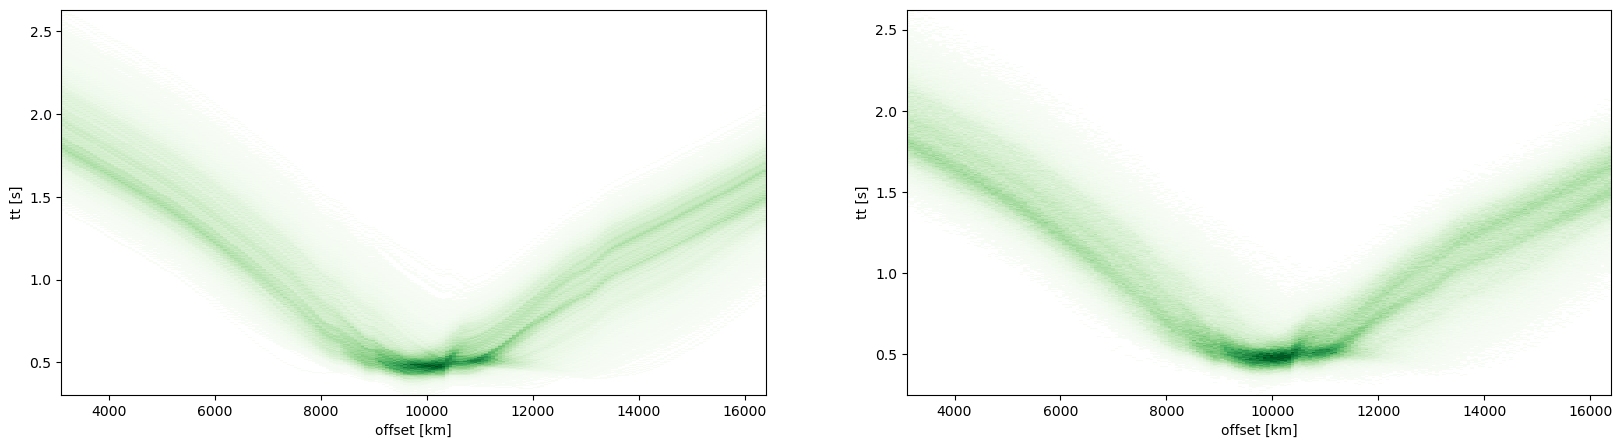

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax_dict = fig.subplot_mosaic('''ab''')

ax_dict['a'].hist2d(designs[:, 0].expand(n_visual, -1).flatten().numpy(),
                    clean_data.flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(designs[:, 0].expand(n_visual, -1).flatten().numpy(),
                    noisy_data.flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)
    
ax_dict['a'].set_ylabel('tt [s]')
ax_dict['b'].set_ylabel('tt [s]')

ax_dict['a'].set_xlabel('offset [km]')
ax_dict['b'].set_xlabel('offset [km]')


# fig.savefig(f'../figures/datadist_gmm_prior.pdf', bbox_inches='tight', dpi=150)
# fig.savefig(f'../figures/datadist_gmm_prior.png', bbox_inches='tight', dpi=150)
                        
plt.show()

In [ ]:
design_budget = 4
n_parallel = 10

In [ ]:
optimal_design_dict = {}
info_dict = {}

In [ ]:
method = 'nmc'

M = int(1e3)
N = int(1e4)
print(f'{N:.1e}')
print(f'{M:.1e}')
print(f'{(N*M):.1e}')

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method='nmc',
    eig_method_kwargs={'N': N, 'M': M, 'reuse_M_samples':False},
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename='data/srcloc_bed_{}.pkl'.format(method),
    )

# print(info_dict[method][1]['eig'])

1.0e+04
1.0e+03
1.0e+07


  0%|          | 0/4 [00:00<?, ?it/s]

/scratch/dstrutz/.conda/envs/fwi_bed/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
method = 'nmc_reuse'

M = int(5e4)
N = int(5e4)
print(f'{N:.1e}')
print(f'{M:.1e}')
print(f'{(N+M):.1e}')

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method='nmc',
    eig_method_kwargs={'N': N, 'M': M, 'reuse_M_samples':True, 'memory_efficient':True},
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=10,
    filename='data/srcloc_bed_{}.pkl'.format(method),
    )

# print(info_dict[method][1]['eig'])

1.0e+04
1.0e+04
2.0e+04


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
method = 'dn'

N = int(1e4)

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method=method,
    eig_method_kwargs={'N': N},
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename='data/srcloc_bed_{}.pkl'.format(method),
    )

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from geobed.guides import GMM_guide

In [ ]:
method = 'variational_marginal'

N = int(5e4)
M = int(5e4)
n_batch = 50
n_epochs = 50

scheduler = torch.optim.lr_scheduler.StepLR

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method=method,
    eig_method_kwargs=
    {'guide': GMM_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'components':40,},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
     'optimizer': None,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': scheduler,
     'scheduler_kwargs': {'step_size':n_epochs//3, 'gamma':0.3},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     },
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename='data/srcloc_bed_{}.pkl'.format(method),
    )

  0%|          | 0/4 [00:00<?, ?it/s]

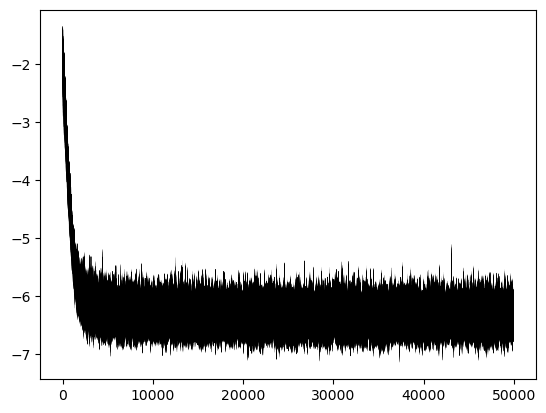

In [ ]:
for i in range(n_designs):
    plt.plot((info_dict['variational_marginal'][4]['info'][i]['train_loss']), color='k', alpha=0.2, linewidth=0.1)
plt.show()

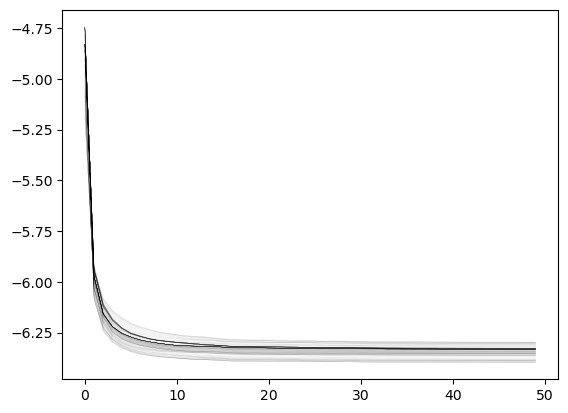

In [ ]:
for i in range(n_designs):
    plt.plot((info_dict['variational_marginal'][4]['info'][i]['test_loss']), color='k', alpha=0.2, linewidth=0.1)
plt.show()

In [ ]:
from geobed.guides import MDN_guide

In [ ]:
method = 'variational_posterior'

N = int(5e4)
M = int(5e4)
n_batch = 50
n_epochs = 50

scheduler = torch.optim.lr_scheduler.StepLR

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method=method,
    eig_method_kwargs=
    {'guide': MDN_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'components':20, 'hidden_features':[40, 40, 40], 'normalize':True},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': scheduler,
     'scheduler_kwargs': {'step_size':n_epochs//6, 'gamma':0.3},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     },
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename='data/srcloc_bed_{}.pkl'.format(method),
    )

  0%|          | 0/4 [00:00<?, ?it/s]

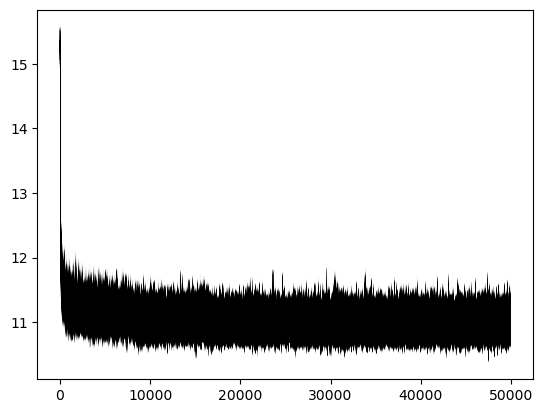

In [ ]:
for i in range(n_designs):
    plt.plot((info_dict['variational_posterior'][4]['info'][i]['train_loss']), color='k', alpha=0.2, linewidth=0.1)
plt.show()

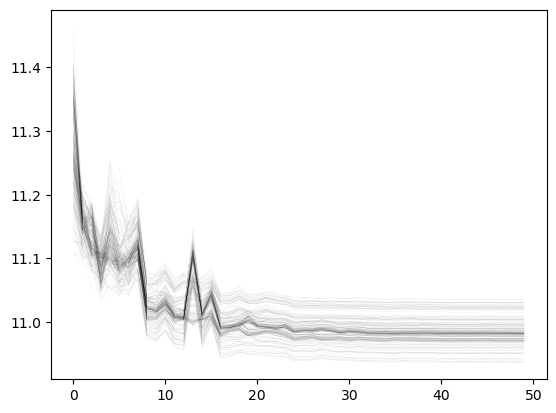

In [ ]:
for i in range(n_designs):
    plt.plot((info_dict['variational_posterior'][4]['info'][i]['test_loss']), color='k', alpha=0.2, linewidth=0.1)
plt.show()

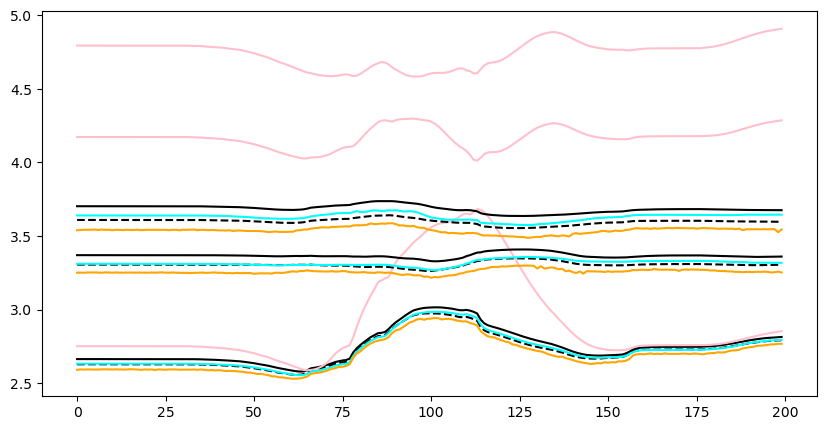

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i in range(2, 4+1):
    ax.plot(info_dict['nmc'][i]['eig'], label='NMC', color='k')
    ax.plot(info_dict['nmc_reuse'][i]['eig'], label='NMC', color='k', linestyle='--')
    ax.plot(info_dict['dn'][i]['eig'], label='DN', color='pink')
    ax.plot(info_dict['variational_marginal'][i]['eig'], label='Var Marg', color='cyan')
    ax.plot(np.array(info_dict['variational_posterior'][i]['eig']), label='Var Post', color='orange')
    
plt.show()

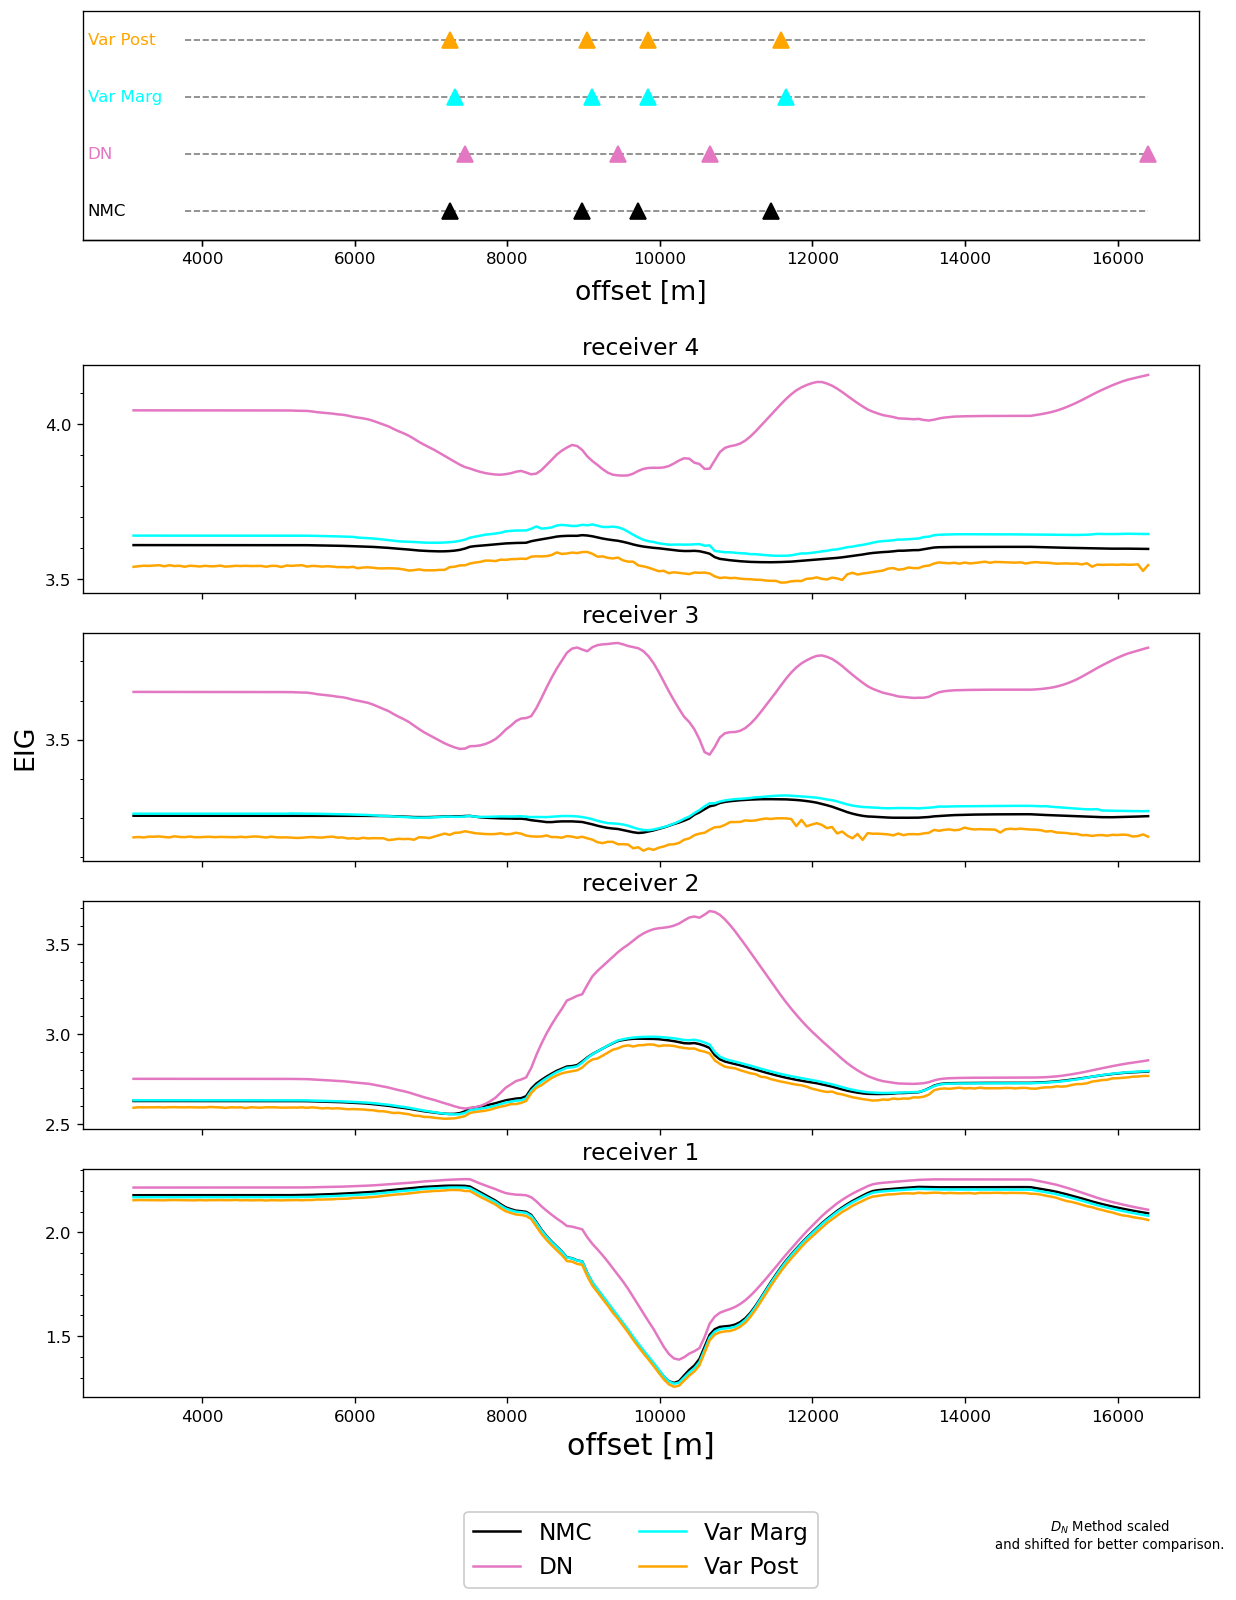

In [ ]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(12, 3*5), dpi=120)
ax_dict = fig.subplot_mosaic(
    '''f
       x
       d
       c
       b
       a''', sharex=True, empty_sentinel='x',
       gridspec_kw={'hspace': 0.2, 'height_ratios':[1.0, 0.2, 1, 1, 1, 1]})

offsets = designs[: ,0]

ax_names = ['a', 'b', 'c', 'd']

gaussian_offsets = [0.0, 0.0, 0.55, 0.75]
gaussian_scalings = [1.0, 1.0, 1.0, 1.0]

methods = ['nmc_reuse', 'dn', 'variational_marginal', 'variational_posterior']

colour_dict = {'nmc': 'black', 'nmc_reuse': 'black', 'dn': 'tab:pink', 'variational_marginal': 'cyan', 'variational_posterior': 'orange'}
label_dict = {'nmc': 'NMC', 'nmc_reuse': 'NMC', 'dn': 'DN', 'variational_marginal': 'Var Marg', 'variational_posterior': 'Var Post'}

for i in range(1, 5):
    for method in methods:
        
        if method != 'dn':
            ax_dict[ax_names[i-1]].plot(offsets, info_dict[method][i]['eig'],
                                        color=colour_dict[method], label=label_dict[method])
            # ax_dict[f'{ax_names[i-1]}'].plot(offsets[[optimal_design_dict[method][i]]],
            #                                  info_dict[method][i][[optimal_design_dict[method][i]]], 
            #                         marker='^', color=colour_dict[method], markersize=10, linestyle="None")
        
        else:
            ax_dict[ax_names[i-1]].plot(offsets, (torch.tensor(info_dict['dn'][i]['eig']) * gaussian_scalings[i-1]) - gaussian_offsets[i-1],
                                color=colour_dict['dn'], label=label_dict['dn'])
        
    ax_dict[ax_names[i-1]].yaxis.set_major_locator(MultipleLocator(0.5))
    ax_dict[ax_names[i-1]].yaxis.set_minor_locator(MultipleLocator(0.1))

    ax_dict[ax_names[i-1]].set_title(f'receiver {i}', size=14)
    
    
ax_dict['a'].set_xlabel(r'offset [m]',  fontsize=18)
ax_dict['c'].set_ylabel(r'EIG', fontsize=16)


for i, method in enumerate(methods):
        
    ax_dict['f'].plot(
        [design_dicts[d_i]['x'] for d_i in optimal_design_dict[method][:4]], np.zeros(len(optimal_design_dict[method][:4])) - 0.3 + 0.2 * i,
        marker='^', color=colour_dict[method], markersize=10, linestyle="None") 

    ax_dict['f'].plot(offsets[10:], np.zeros_like(offsets[10:]) - 0.3 + 0.2 * i, color='grey', linewidth=1.0, linestyle='--', zorder=-10)
    
    ax_dict['f'].text(2500, -0.3 + 0.2 * i, label_dict[method],
                      fontsize=10, verticalalignment='center', horizontalalignment='left', color=colour_dict[method])

def f(x):
    return x

ax_dict['f'].set_ylim((-0.4, 0.4))

ax_dict['f'].set_yticks([])

ax_dict['f'].secondary_xaxis('bottom', functions=(f, f))
ax_dict['f'].set_xlabel(r'offset [m]', fontsize=16, labelpad=20)


ax_dict['f'].tick_params(labelleft=False, )

leg = ax_dict['a'].legend(loc='upper center', bbox_to_anchor=(0.5, -0.45),
                          fontsize=14, fancybox=True, facecolor='white', framealpha=1, ncol=2)

ax_dict['a'].text(0.92, -0.6,'$D_N$ Method scaled\nand shifted for better comparison.', transform=ax_dict['a'].transAxes,
                  fontsize=8, verticalalignment='center', horizontalalignment='center')

fig.savefig(f'figures/5rec2mod_srcloc_noise.pdf', bbox_inches='tight', dpi=120)
fig.savefig(f'figures/5rec2mod_srcloc_noise.png', bbox_inches='tight', dpi=120)

plt.show()